# Semantic, Lexical and Hybrid Search 

In [ ]:
#This cell installs the required libraries specified in the 'requirements.txt' file
#!pip install -r requirements.txt --quiet


In [1]:
# load required libraries 
import os
import pandas as pd
import sagemaker
import boto3
import json
import pprint
import random 
from PIL import Image
from IPython.display import display
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth, helpers
import time

session = boto3.session.Session()
region_name = session.region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


Load the utility library from the src folder which contains various functions for this notebook ease of use and simplicy. 

In [19]:
#adding our utils library to sys path
import sys
sys.path.append("./src/helpers/")
from utils import *

Before we begin conducting search let us reload the required datasets and variables from previous notebooks 

In [2]:
# load the dataset from notebook 2 
%store -r df_metadata
# df_metadata = pd.read_csv('./data/enriched_dataset.csv')
df_metadata.head()

image_id                                        path  \
0  00c73a28068f9b33.jpg  ./data/curated-images/00c73a28068f9b33.jpg   
1  00a7655d4eabf186.jpg  ./data/curated-images/00a7655d4eabf186.jpg   
2  039928928a45ca04.jpg  ./data/curated-images/039928928a45ca04.jpg   
3  07080581c9f69bf9.jpg  ./data/curated-images/07080581c9f69bf9.jpg   
4  0a1a999ef52a93f2.jpg  ./data/curated-images/0a1a999ef52a93f2.jpg   

                                               title  \
0                   Majestic Mountain Lion in Repose   
1                       Baseball batter in mid-swing   
2  Music Production Setup with Guitar and Accesso...   
3          Musicians performing in an office setting   
4                   Majestic Lion in Natural Habitat   

                                         description  \
0  The image captures a magnificent mountain lion...   
1  The image depicts a baseball player in the mid...   
2  The image depicts a music production setup wit...   
3  The image depicts three young men dressed in f...   
4  The image depicts a magnificent lion with a fu...   

                                            keywords  \
0  mountain lion, cougar, puma, big cat, wildlife...   
1  baseball, batter, swing, game, sports, athlete...   
2  guitar, music production, electric guitar, fre...   
3  musicians, music performance, office, workspac...   
4  lion, wildlife, nature, safari, big cat, preda...   

                                               tags  \
0             nature, animal, mammal, wild, outdoor   
1        baseball, sports, athlete, batting, action   
2      music, instruments, recording, studio, setup   
3   music, office, performance, instruments, formal   
4  animal, mammal, feline, carnivore, wild, outdoor   

                                          embeddings  
0  [0.0060814563, -0.013978273, -0.00027939526, -...  
1  [0.049273923, 0.015161207, -0.02124564, 0.0232...  
2  [0.014198928, -0.01178779, -0.027862048, -0.02...  
3  [0.029886922, 0.019172743, -0.028383177, 0.016...  
4  [-0.009729036, 0.027665507, -0.009314054, -0.0...

In [5]:
# save variables for use in search notebook
%store -r index_name
%store -r collection_name
%store -r host

print("opensearch host:{0}, index:{1}, collection:{2}".format(host, index_name, collection_name))

opensearch host:vpdj3ctgv0rmukhasyi.us-east-1.aoss.amazonaws.com, index:smart-search-index, collection:media-search-229


## Preparing the OSS Client

This section demonstrates how to search the index using vector embeddings and the k-nearest neighbors (KNN) algorithm as well as conduct classic lexical search in OSS. It generates an embedding for a given query text as well as a reference image, constructs a KNN query, and retrieves the top k most relevant documents from the index.


Before we can query, we first need to build a client using the opensearch library. The following cell builds a client using the current users credentials as well as the host name we saved in previous notebook. 

In [7]:
# create the collection of type vector search
oss_client = boto3.client('opensearchserverless')
# create the OSS client
service = 'aoss'
credentials = boto3.Session().get_credentials()
awsauth = AWSV4SignerAuth(credentials, region_name, service)


# Build the OpenSearch client
search_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=300
)

## Search the index 

In this section, we will be conducting various styles of searches with opensearch from classic Lexical search using keywords and query matching, to more advanced vector search using the KNN algorithm as well as hybrid searches. 

The purpose is to provide a clear indication of the varying output when text vector are used over direct image embeddings. 

### OSS DSL queries
The code cell below builds a opensearch DSL queries payload before calling opensearch via the search client. 

Two functions are defined here to conduct lexical as well as embeddings search using the KNN algorithm in opensearch. For the similarity search using embeddings it requires an additoinal k parameter to find k number of nearest neighbors from the vector space. In literal terms this will find k number of similar items that are closest to the input emebeddings in euclidean distance. Opensearch directly does this evaluation therefore we only need to specify the number of neighbors. 

In [185]:
# lexical search augmented with enrichment via Gen AI
search_term = "baseball player blue jersey swinging bat"

def query_text_description(search_term, hits=10):
    query = {
        "query": {
            "match": {
                "title": {
                    "query": search_term
                }
            }
        },
        "_source": {
            "exclude": ["image_vector"], # exclude vectors from the response
        },
        "size": hits
    }
    
    search_response = search_client.search(body=query, index=index_name)
    return search_response

def query_similarity(query_emb, hits=10, k=5):
    
    body = {
            "query": {
                "knn": {
                    "image_vector": {
                        "vector": query_emb,
                        "k": k,
                    }
                }
            },
            "_source": {
                "exclude": ["image_vector"],
            },
            "size": hits
    }     

    search_response = search_client.search(index=index_name, body=body)
    return search_response



### Lexical search 

The cell below utilises a utility function to display results as images from the util library by mapping the file name in our dataset and locating the path. This is done to keep the notebook less verbose. For subsequent scenarios where image previous are required from search results we are going to be utilising the same utility function. 

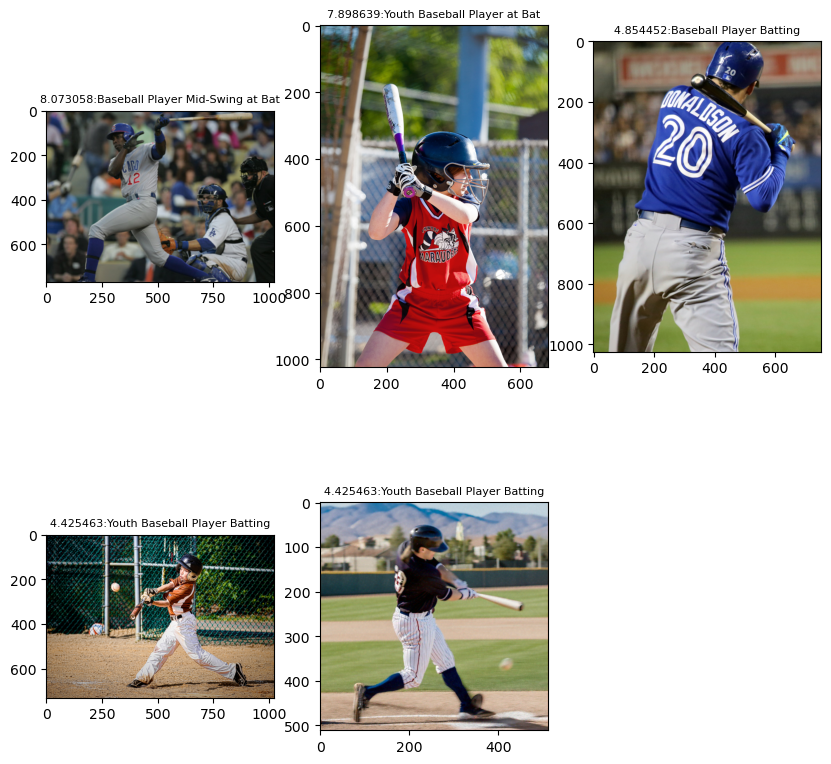

In [186]:
results_lexical = query_text_description(search_term, 5)
display_results(results_lexical, df_metadata)

In [224]:
# reload 
%load_ext autoreload
%autoreload 2
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Semantic search using text embeddings

In this section we will conduct the same search but this time utilise the titan text embeddings to convert the search term into vector embeddings and conduct a vector search using the KNN algorithm. 

Since the query term needs to be converted to a vector first, we will call a method in the utility library which in turn calls titan multi-modal embedding model to generate the query embeddings.

Note: For this search to be functional we are required to call the same embeddings model that is used for the image embeddings task. In data enrichment notebook, we utilised Titan Multimodal Embeddings G1 model and will be using the same for query embeddings. 


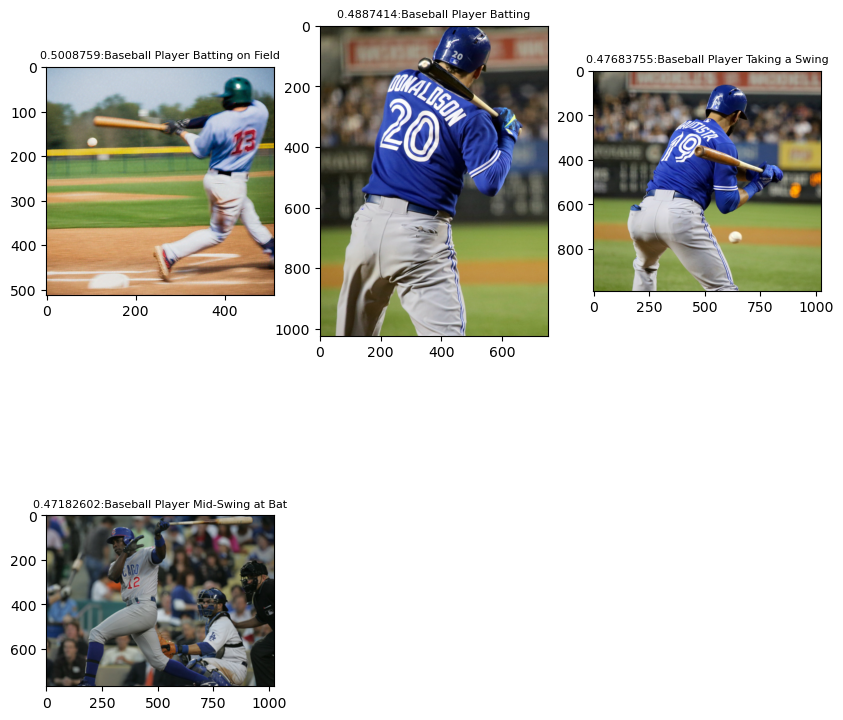

In [188]:
query_emb = get_titan_multimodal_embedding(description=search_term, dimension=1024)["embedding"]
results_semantic_text = query_similarity(query_emb, hits=5, k=1)
display_results(results_semantic_text, df_metadata)

### Semantic search using Image embeddings

In order for the search to take into account finder semantic meanings we can utilise a reference image as well as text for query embeddings. This will allow specific properties of hte image to be embedded into the vector space therefore return a tighter result set. 


The following cell generates a base image using titan image generator for the purpose of search 


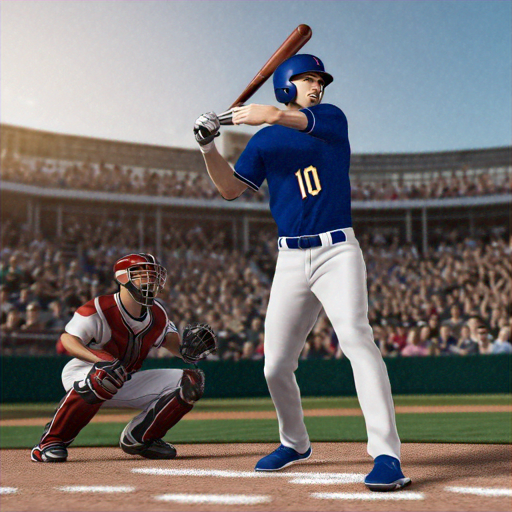

In [216]:
prompt = "ultra photorealistic professional baseball player blue jersey about to hit a home run, ballfield, spectators"
neg_prompt = "blurry, low quality, distorted"
test_img = generate_titan_image(prompt=prompt,neg_prompt=neg_prompt, seed=random.randint(1,9))
path = "./data/testimg.png"
test_img.save(path)
test_img

Use the test image as reference image to now conduct a similarity search. 

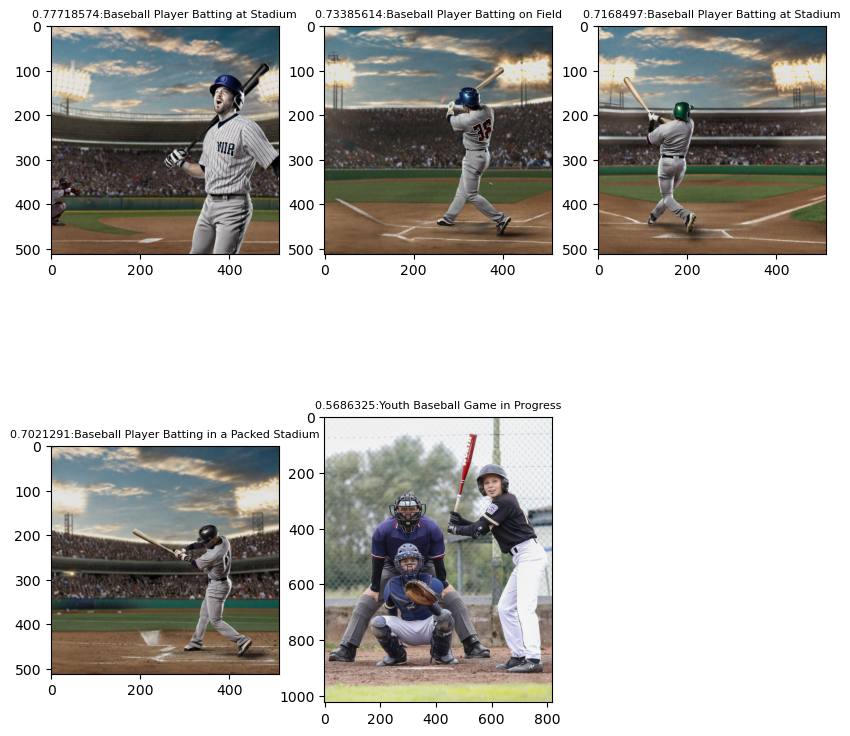

In [217]:
query_emb = get_titan_multimodal_embedding(image_path=path, dimension=1024)["embedding"]
results_semantic_img = query_similarity(query_emb, hits=5, k=2)
display_results(results_semantic_img, df_metadata)

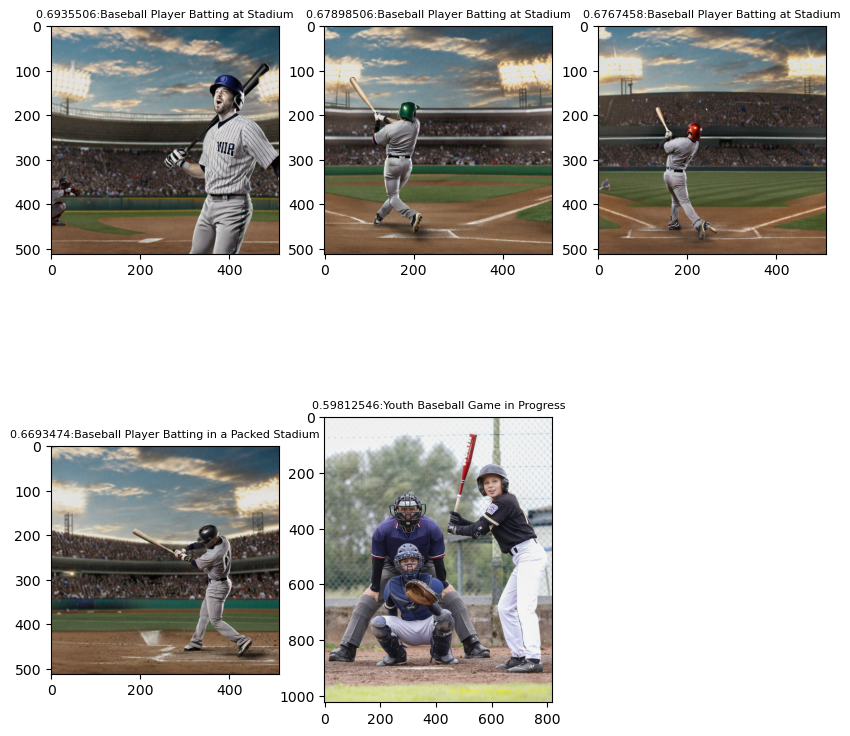

In [223]:
optional_description = "similar image with player catching the ball"
query_emb = get_titan_multimodal_embedding(image_path=path, description=optional_description, dimension=1024)["embedding"]
results_semantic_img = query_similarity(query_emb, hits=5, k=2)
display_results(results_semantic_img, df_metadata)

### Semantic search using generated description

For this step, we are going to extract text description of the image using Claude Sonnet which in turn will be used to carry out embeddings search. 

In [235]:
prompt = """
You are a multimodal search engine metadata extractor. Your task is to carefully study the image and generate a text description of the image.
Be detailed on various aspects of the image such as background, foreground, subject, and other finer details of the image.

Make necessary determination on the key category/theme of the image and generate description as appropriate. 

Description generated is required to be professional for official use. Refrain from using informal language. 

The intended audience are various business users who will attempt to search based on a description in natural language of what they are looking for.  

Output the description as plain text only. 
"""

In [237]:
res=generate_img_desc(prompt=prompt, img_path=path)
pprint.pp(res)

('The image depicts a baseball game scene. In the foreground, there is a '
 'batter in a blue uniform with the number 10 on his jersey, taking a swing '
 'with a baseball bat. The batter appears to be in mid-swing, with his body '
 'twisted and his arms extended, suggesting a powerful hit. Behind the batter, '
 'there is a catcher in a red uniform, crouched in a defensive position, ready '
 'to receive the pitch. The background shows a large baseball stadium filled '
 'with spectators, indicating a professional or major league game. The image '
 'captures the intense moment of a batter making contact with the ball, '
 'conveying the energy and excitement of the sport.')


use the description of the image as the source text embedding.

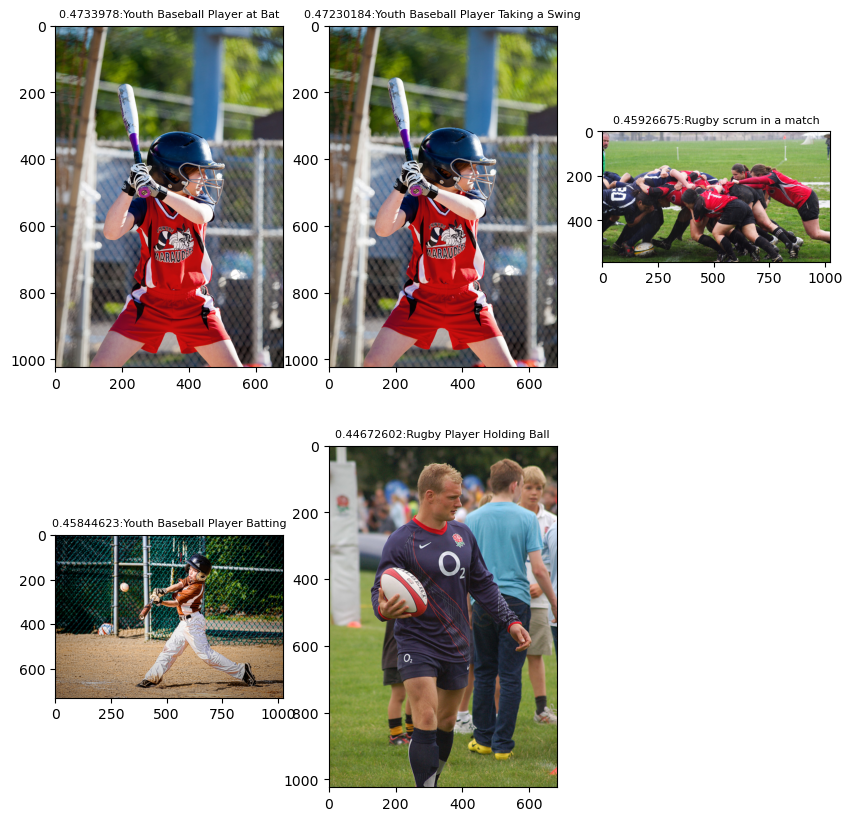

In [240]:
optional_description = "similar image but must contain youth wearing a red jersey" # this can be user supplied text in addition to the image
search_term = res + optional_description
query_emb = get_titan_multimodal_embedding(description=optional_description, dimension=1024)["embedding"]
results_semantic_img = query_similarity(query_emb, hits=5, k=2)
display_results(results_semantic_img, df_metadata)